In [840]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , LSTM , Dense , Attention , Dropout ,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import LabelEncoder
import re
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [841]:
data = pd.read_csv('./../edos/data/edos_labelled_aggregated.csv')

In [842]:
data.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [843]:
data = data[['label_sexist' , 'text' , 'split']]

In [844]:
data['split'].unique()

array(['dev', 'train', 'test'], dtype=object)

In [845]:
label_encoder = LabelEncoder()
data['label_sexist'] = label_encoder.fit_transform(data['label_sexist'])

In [846]:
num_classes = len(set(data['label_sexist'])) 
data['label_sexist'] = to_categorical(data['label_sexist'], num_classes=num_classes)

In [847]:
def clean_text(text):
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text).strip()
    return text


In [848]:
data['text'] = data['text'].apply(clean_text)


In [849]:
data

,label_sexist,text,split
0,1.0,in nigeria if you rape a woman the men rape yo...,dev
1,1.0,then she s a keeper,train
2,1.0,this is like the metallica video where the poo...,train
3,1.0,woman,train
4,1.0,i bet she wished she had a gun,dev
...,...,...,...
19995,1.0,girls really get fucked almost every weekend,train
19996,1.0,the hatred for moslems are reasonable and just...,train
19997,1.0,now this is a woman who gets it,train
19998,1.0,american idol finalist user said nothing is go...,train


In [852]:
train = data[data['split'] == 'train']
val = data[data['split'] == 'dev']
test = data[data['split'] == 'test']

In [853]:
def Xandy(data):
    X = data.drop(['label_sexist'], axis=1)
    y = data.label_sexist
    return X,y

In [854]:
X_train, y_train = Xandy(train)
X_val, y_val = Xandy(val)

In [855]:
texts_train = X_train['text'].tolist()
text_val = X_val['text'].tolist()
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train)
X_train_sequences = tokenizer.texts_to_sequences(texts_train)
#=============================================================
tokenizer.fit_on_texts(text_val)
X_val_sequences = tokenizer.texts_to_sequences(text_val)
#=============================================================
# Pad sequences to ensure they have the same length
max_sequence_length = 70  # You can choose an appropriate length based on your data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)

In [856]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


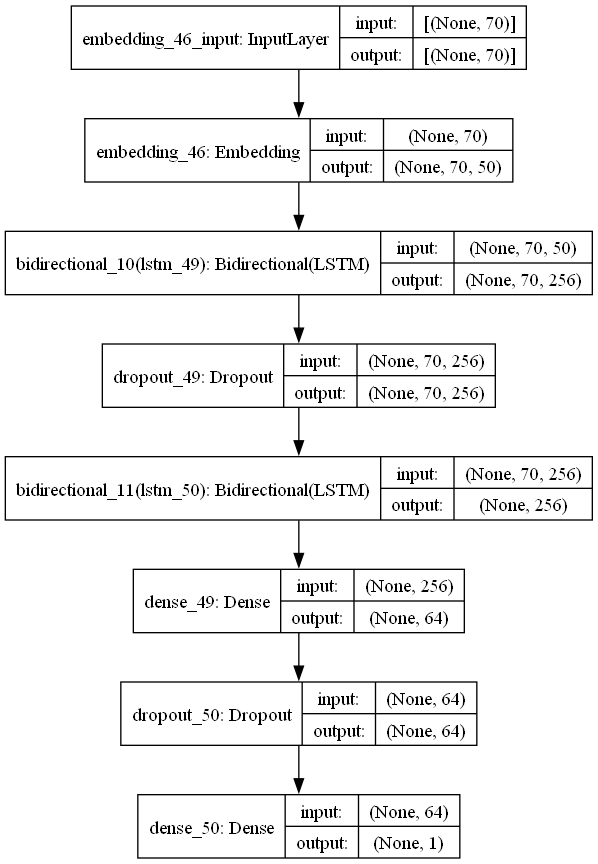

In [857]:
plot_model(model, show_shapes=True)

In [858]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 1 to 19998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14000 non-null  object
 1   split   14000 non-null  object
dtypes: object(2)
memory usage: 328.1+ KB


In [859]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 

In [860]:
model.fit(X_train_padded, y_train, epochs=10, batch_size=42, callbacks=[early_stopping], validation_data=(X_val_padded, y_val))

Epoch 1/10
334/334 [==============================] - 11s 22ms/step - loss: 0.6249 - accuracy: 0.7746 - val_loss: 0.6682 - val_accuracy: 0.7120
Epoch 2/10
334/334 [==============================] - 7s 20ms/step - loss: 0.3899 - accuracy: 0.8436 - val_loss: 0.7061 - val_accuracy: 0.6990
Epoch 3/10
334/334 [==============================] - 7s 20ms/step - loss: 0.3473 - accuracy: 0.8589 - val_loss: 0.8608 - val_accuracy: 0.6865
Epoch 4/10
334/334 [==============================] - 7s 20ms/step - loss: 0.2975 - accuracy: 0.8841 - val_loss: 0.7536 - val_accuracy: 0.6730
Epoch 5/10
334/334 [==============================] - 7s 20ms/step - loss: 0.2610 - accuracy: 0.9046 - val_loss: 1.0339 - val_accuracy: 0.6520
Epoch 6/10
334/334 [==============================] - 7s 20ms/step - loss: 0.2256 - accuracy: 0.9216 - val_loss: 0.9588 - val_accuracy: 0.6125


In [861]:
model.save('sexism.h5')

Now let's test

In [862]:
X_test , y_test = Xandy(test)

In [863]:
texts_test = X_test['text'].tolist()
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_test)
X_test_sequences = tokenizer.texts_to_sequences(texts_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [864]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

125/125 [==============================] - 2s 8ms/step - loss: 0.6648 - accuracy: 0.7243
